In [73]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show code"></form>''')

<a id='index'></a>
# Content-based image retrieval

- [Descriptors](#descriptors)
    - [CNN Descriptor](#cnn_descriptor)
    - [Color Descriptor](#color_descriptor)
    - [Texture Descriptor](#texture_descriptor)
    - [Bag of visual words (BOvW) Descriptor](#bovw_descriptor)
- [Results](#results)
    - [CNN](#cnn)
    - [Color](#color)
    - [BOvW](#bovw)
    - [CNN and Color](#cnn_color)

In [74]:
import re
import os
import cv2
import time
import glob as gb
import numpy as np
import pandas as pd
from copy import deepcopy
from dateutil import parser
from functools import partial

import scipy as sp

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.preprocessing import normalize as norm, StandardScaler, MinMaxScaler

from skimage.color import label2rgb
from skimage.transform import rotate
from skimage.feature import local_binary_pattern, hog

from keras.utils import np_utils
from keras.optimizers import SGD
from keras.regularizers import l2, l1
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint 
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D, GlobalAveragePooling2D, BatchNormalization

import pylab as plt 
%matplotlib inline 

In [75]:
def load_data(path_to_data):
    data = {'name'  : [],
            'image' : []}
            
    for img_path in gb.glob('/'.join([path_to_data, '*'])):
        data['name'].append(os.path.basename(img_path))
        img = cv2.imread(img_path)
        data['image'].append(cv2.resize(img, (299, 299)))
        
    return pd.DataFrame(data)

data = load_data('holiday_dataset')

<a id='descriptors'></a>
## Descriptors
[back to index](#index)

<a id='cnn_descriptor'></a>
### CNN Descriptor
[back to index](#index)

In [76]:
class CNNClassifier:
    def __init__(self, img_size=(299, 299)):
        self.img_size = img_size
        self.model = InceptionV3(weights='imagenet')
        
    def predict(self, img, top=3):
        x = img.astype('float32')
        if x.shape[:2] != self.img_size:
            x = cv2.resize(x, self.img_size)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        y = self.model.predict(x)
        
        return decode_predictions(y, top=3)[0]


class CNNDescriptor:
    def __init__(self, img_size=(299, 299)):        
        self.img_size = img_size
        self.base_model = InceptionV3(weights='imagenet', include_top=False)
        x = self.base_model.output
        x = GlobalAveragePooling2D()(x)
        self.model = Model(inputs=self.base_model.input, outputs=x)
        
    def describe(self, img):
        x = img.astype('float32')
        if x.shape[:2] != self.img_size:
            x = cv2.resize(x, self.img_size)
        x = np.expand_dims(x, axis=0)
        
        return self.model.predict(preprocess_input(x))

<a id='color_descriptor'></a>
### Color Descriptor
[back to index](#index)

In [96]:
class ColorDescriptor:
    def __init__(self, bins):
        self.bins = bins
        
    def histogram(self, img, bins, mask=None):
        hist = cv2.calcHist([img], [0, 1, 2], mask, self.bins, [0, 180, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        
        return hist.flatten()
        
    def describe(self, img):
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        h, w = hsv_img.shape[:2]
        c_x, c_y = w // 2, h // 2

        segments = [[0, c_x, 0, c_y],
                    [c_x, w, 0, c_y], 
                    [c_x, w, c_y, h],
                    [0, c_x, c_y, h]]

        ellipse_x, ellipse_y = int(w * 0.75) // 2, int(h * 0.75) // 2
        ellipse_mask = np.zeros(hsv_img.shape[:2], dtype = 'uint8')
        cv2.ellipse(ellipse_mask, (c_x, c_y), (ellipse_x, ellipse_y), 0, 0, 360, 255, -1)

        features_vector = [self.histogram(hsv_img, self.bins, ellipse_mask)]

        for start_x, end_x, start_y, end_y in segments:
            corner_mask = np.zeros(hsv_img.shape[:2], dtype = 'uint8')
            cv2.rectangle(corner_mask, (start_x, start_y), (end_x, end_y), 255, -1)
            corner_mask = cv2.subtract(corner_mask, ellipse_mask)

            features_vector.extend(self.histogram(hsv_img, self.bins, corner_mask))
            
        return np.squeeze(sp.sparse.hstack(features_vector).toarray()).reshape(1, -1)

<a id='texture_descriptor'></a>
### Texture Descriptor
[back to index](#index)

In [78]:
class TextureDescriptor:
    def __init__(self, num_pts=24, radius=8, eps=1e-7, method='uniform'):
        self.num_pts = num_pts
        self.radius = radius
        self.method = method
        self.eps = eps

    def __extract(self, img):
        lbp = local_binary_pattern(img, self.num_pts, self.radius, self.method)
        hist, _ = np.histogram(lbp.ravel(),
                               bins=np.arange(0, self.num_pts + 3), 
                               range=(0, self.num_pts + 2))

        hist = hist.astype("float") 
        
        return norm(hist.reshape(1, -1))
        
    def describe(self, img):        
        H, W = img.shape[:2]
        gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        features_vector = []

        h, w = H // 10, W // 10
        
        for x in range(0, W, w):
            for y in range(0, H, h):
                features_vector.extend(self.__extract(gray_scale[y:y + h, x:x + w]))
            
        return np.array(features_vector).reshape(1, -1)

<a id='bovw_descriptor'></a>
### Bag of visual words Descriptor
[back to index](#index)

In [120]:
class ShapeDescriptor:
    def __init__(self):
        self.detector = cv2.xfeatures2d.SIFT_create()

    def describe(self, img):
        gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kps, descs = self.detector.detectAndCompute(gray_scale, None)
        return kps, descs


class BOvW(ShapeDescriptor):
    def __init__(self, n_clusters=20, norm='l2', n_jobs=1):
        super().__init__()
        self.n_clusters = n_clusters
        self.n_jobs = n_jobs
        self.norm = norm
        
    def __extract_features(self, X):
        stack = self.describe(X[0])[1]
        descriptors = []
        
        for idx, x in enumerate(X[1:]):
            try:
                features = self.describe(x)[1]
                stack = np.vstack((stack, features))
                descriptors.append(features)
            except:      
                print('Example #%d failed! Features extracted: %r' % (idx+1, features))
        
        return stack, descriptors
                
    def __fit(self, stack):    
        self.k_means = KMeans(n_clusters=self.n_clusters, n_jobs=self.n_jobs)
        return self.k_means.fit_predict(stack)
                       
    def __transform(self, cluster_labels, descriptors):   
        histograms = np.array([np.zeros(self.n_clusters) for i in range(len(descriptors))])

        for i in range(len(descriptors)):
            for j in range(len(descriptors[i])):            
                histograms[i][cluster_labels[i+j]] += 1    
    
        if self.norm != None:
            histograms = norm(histograms, self.norm)
        
        return histograms

    def fit(self, X):
        stack, descriptors = self.__extract_features(X)
        self.__fit(stack)
        return self
    
    def fit_transform(self, X):
        stack, descriptors = self.__extract_features(X)
        cluster_labels = self.__fit(stack)
        return self.__transform(cluster_labels, descriptors)
    
    def transform(self, X):
        stack, descriptors = self.__extract_features(X)
        cluster_labels = self.k_means.predict(stack)
        return self.__transform(cluster_labels, descriptors)

[back to index](#index)

In [80]:
def chi2_distance(A, B):
    return 0.5 * np.sum([((a - b) ** 2) / (a + b + 1e-5) for (a, b) in zip(A, B)])


def normalised_euclidean_distance(Q, P):
    '''returns values in range[0.0-1.0]'''
    mean_q, mean_p = np.mean(Q), np.mean(P)
    result = np.sum([(p - mean_p - q + mean_q) ** 2 for p, q in zip(P, Q)]) / \
             np.sum([((p - mean_p) ** 2 + (q - mean_q) ** 2) for p, q in zip(P, Q)])
    return 0.5 * result


def percentage_match(Q, P):
    match = 1 - normalised_euclidean_distance(Q, P)
    return 100 * match

[back to index](#index)

In [81]:
cnn_classifier = CNNClassifier()
cnn_descriptor = CNNDescriptor()

In [97]:
color_descriptor = ColorDescriptor((8, 12, 3))

In [98]:
def extract_features(img, what_features):
    '''
        img
            np.array
            
        what_features
            {'cnn', 'color', 'cnn-color'}
    '''    
    if what_features == 'cnn':
        return norm(cnn_descriptor.describe(img), 'l2')
    
    if what_features == 'color':
        return norm(color_descriptor.describe(img), 'l2')
    
    if what_features == 'cnn-color':
        return np.hstack((norm(cnn_descriptor.describe(img), 'l2'),
                          norm(color_descriptor.describe(img), 'l2'))) 

In [84]:
def test(query_name, X, n_neighbors=6):
    query_index = data[data['name'] == query_name].index.tolist()[0]
    query = data.iloc[query_index]
    
    predictions = cnn_classifier.predict(query['image'])
    predictions = '\n'.join(['%s (%d%%)' % (label, prob * 100) for (_, label, prob) in predictions])

    results = kNN.kneighbors(X[query_index].reshape(1, -1), n_neighbors=n_neighbors)
    neighbors = [data.iloc[idx] for idx in results[1][0]]
    distances = [distance for distance in results[0][0]]

    fig = plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(query['image'], cv2.COLOR_RGB2BGR))
    plt.title('Query image\n\n%s' % predictions)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(ncols=len(neighbors), figsize=(14, 12))
    fig.suptitle('Closest neighbours')
    for i in range(ax.shape[0]):
        predictions = cnn_classifier.predict(neighbors[i]['image'])
        predictions = '\n'.join(['%s (%d%%)' % (label, prob * 100) for (_, label, prob) in predictions])

        ax[i].set_title('Distance: %.3f\n\n%s' % (distances[i], predictions))
        ax[i].imshow(cv2.cvtColor(neighbors[i]['image'], cv2.COLOR_RGB2BGR))
        ax[i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=1.5)
    plt.show()

<a id='results'></a>
## Results

<a id='cnn'></a>
### CNN
[back to index](#index)

In [85]:
data['cnn_features'] = data['image'].apply(lambda img: extract_features(img, 'cnn'))

In [86]:
X = np.array([np.squeeze(x) for x in data['cnn_features'].values])

print(X.shape)

(812, 2048)


In [87]:
kNN = NearestNeighbors(metric='euclidean', radius=2.0, algorithm='ball_tree', n_jobs=-2).fit(X)

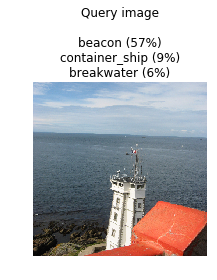

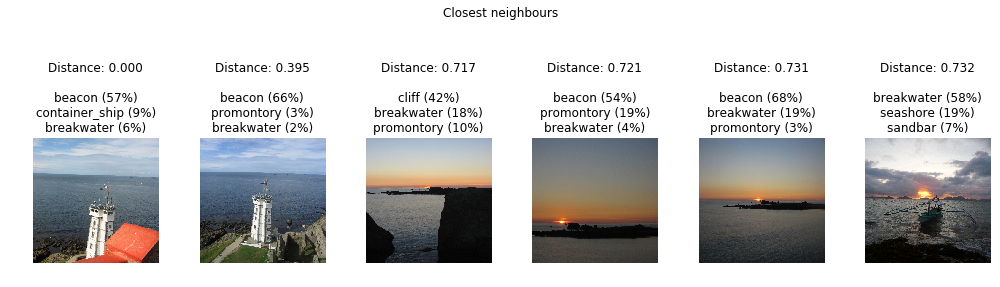

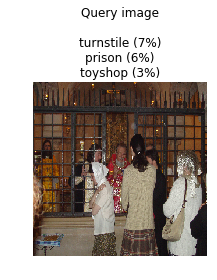

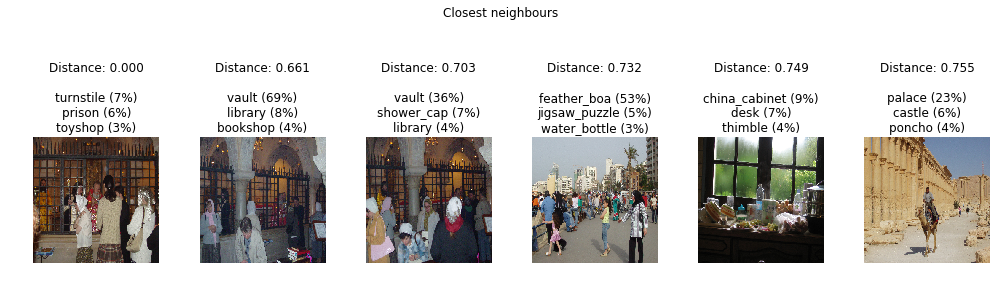

In [88]:
test('102200.jpg', X)
test('118402.jpg', X)

<a id='color'></a>
### Color
[back to index](#index)

In [99]:
data['color_features'] = data['image'].apply(lambda img: extract_features(img, 'color'))

In [100]:
X = np.array([np.squeeze(x) for x in data['color_features']])

print(X.shape)

(812, 1440)


In [101]:
kNN = NearestNeighbors(metric=chi2_distance, radius=2.0, algorithm='ball_tree', n_jobs=-2).fit(X)

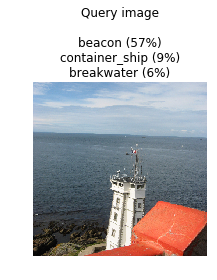

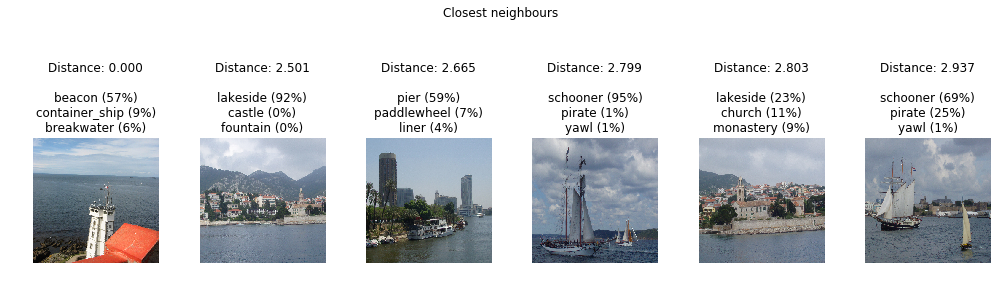

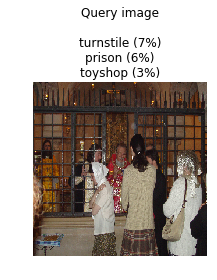

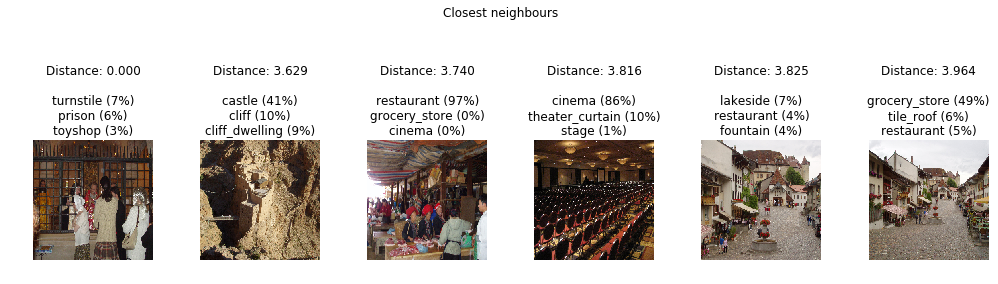

In [102]:
test('102200.jpg', X)
test('118402.jpg', X)

<a id='bovw'></a>
### BOvW
[back to index](#index)

In [119]:
bovw = BOvW(n_jobs=-2)
X = bovw.fit_transform(data['image'])

print(X.shape)

Example #696 failed! Features extracted: None
Example #697 failed! Features extracted: None
Example #698 failed! Features extracted: None
Processing 807/808
(808, 20)


In [123]:
for idx in [696, 697, 698]:
    data = data[data['name'] != data['name'][idx]]

In [134]:
kNN = NearestNeighbors(metric='euclidean', radius=3.0, algorithm='ball_tree', n_jobs=-2).fit(X)

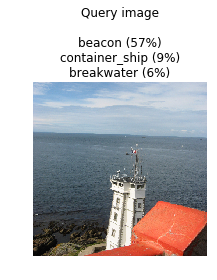

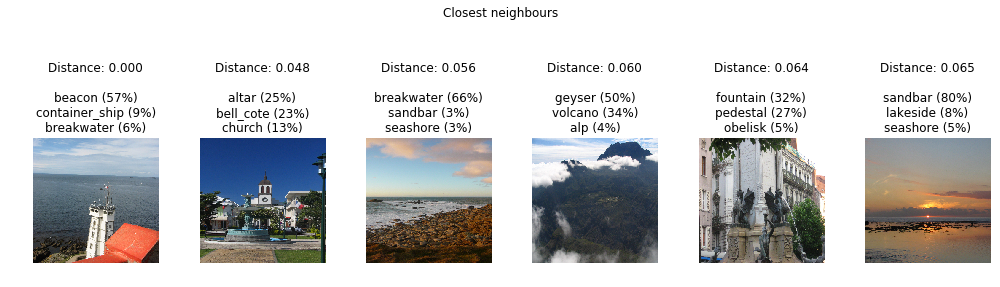

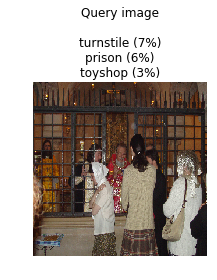

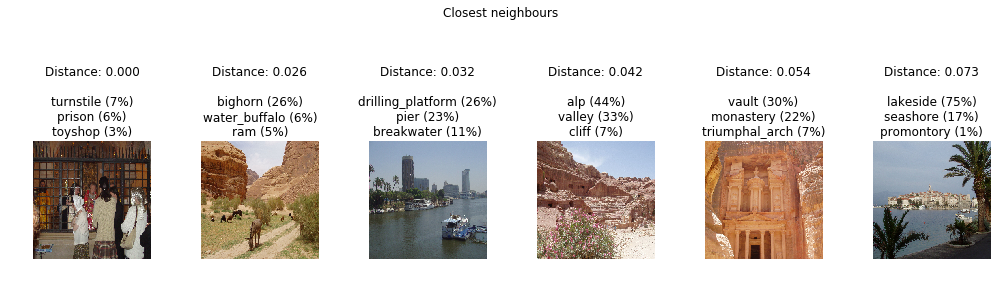

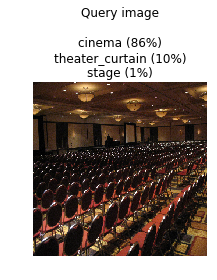

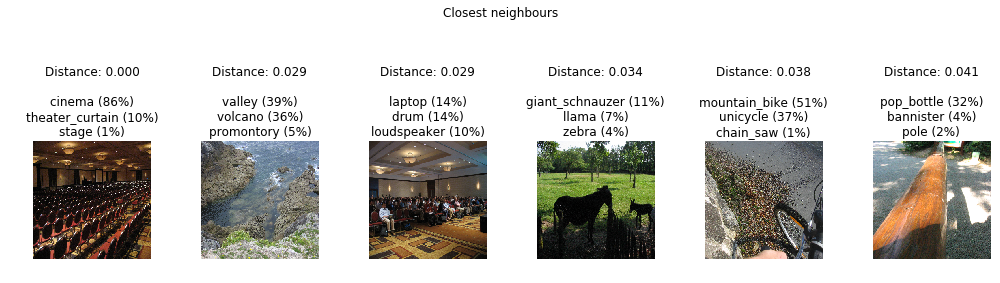

In [135]:
test('102200.jpg', X)
test('118402.jpg', X)
test('125100.jpg', X)

<a id='cnn_color'></a>
### CNN and Color
[back to index](#index)

In [103]:
cnn_features = np.array([np.squeeze(x) for x in data['cnn_features'].values])
print(cnn_features.shape)

color_features = np.array([np.squeeze(x) for x in data['color_features'].values])
print(color_features.shape)

X = np.hstack((cnn_features, color_features))
print(X.shape)

(812, 2048)
(812, 1440)
(812, 3488)


In [104]:
kNN = NearestNeighbors(metric='euclidean', radius=3.0, algorithm='ball_tree', n_jobs=-2).fit(norm(X))

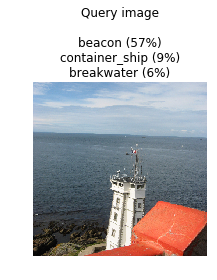

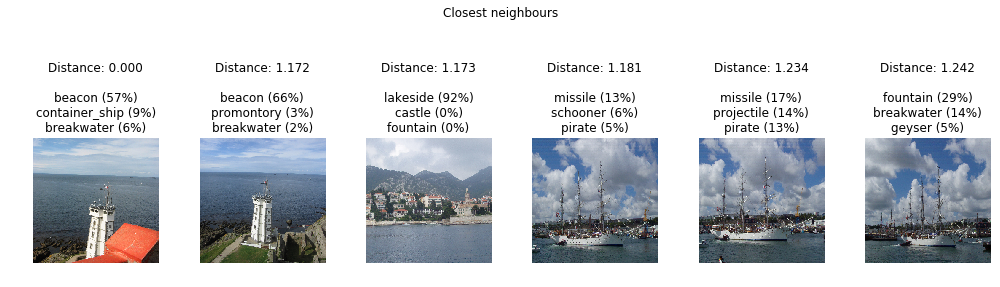

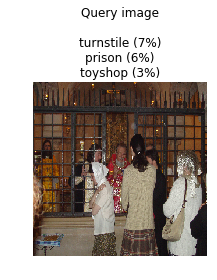

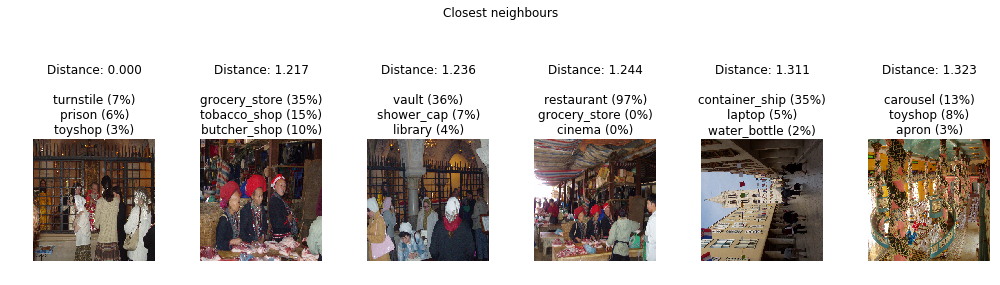

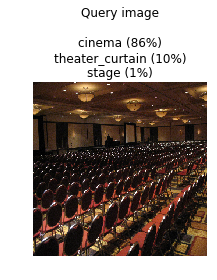

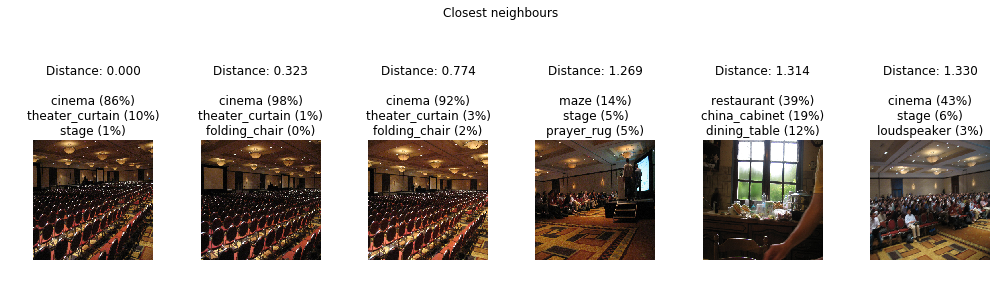

In [106]:
test('102200.jpg', X)
test('118402.jpg', X)
test('125100.jpg', X)